In [1]:
from numpy import *; from numpy.core.records import fromarrays
from matplotlib.pyplot import *
import sys; sys.path.insert(0,'/home/noah/Desktop/large_analysis/ca_analysis/'); import os
import predefined as pd; import fileread as fr
import pickle
from scipy.signal import fftconvolve; from scipy.optimize import curve_fit
import time


#### Reading in detector response pars

In [2]:
with open('/home/noah/Desktop/large_analysis/ca_analysis/detector_response/detector_response.pickle','rb') as f:
    detector_response=pickle.load(f)               #Loading det. repsp. widths (gaussian smearing)

#### Initializing simulation data

In [3]:
bins,rang=500,[0,400]

path='/home/noah/Desktop/large_analysis/zeck_simulation/ca_small_set/'
b0,b1=load(path+'45Ca_b0.npy'),load(path+'45Ca_b1.npy')               # Reading in 45Ca b=1 b=0 PENELOPE spectra
b0,b1=pd.sim_restructure(b0),pd.sim_restructure(b1)                   # Restructuring the sim data
b0,b1=b0.view(recarray),b1.view(recarray)                             # Making the spectra record arrays (easier)
Fullb0,Fullb1=pd.sim_comb_single_pixel(b0),pd.sim_comb_single_pixel(b1)  #Perfect summed simulated spectra
Fullb0,Fullb1=Fullb0.view(recarray),Fullb1.view(recarray)
Fullb0_hist=histogram(Fullb0.energy,bins=bins,range=rang)[0]
Fullb1_hist=histogram(Fullb1.energy,bins=bins,range=rang)[0]
Norm_b = np.sum(Fullb0_hist)/np.sum(Fullb1_hist)        # This is used later when taking difference of b=1 and b=0 spectra

#### Smearing the simulated data & making simulated multi-pixel spectra

In [56]:
thresh=50                       # in keV
coinc_window=400e-9
bdchs=[11,12,35,6]
trutharray=zeros(len(b0),dtype=bool)

trutharray= ((b0.board==2)+(b0.board==5))*(b0.channel==1)  #Removing 77E/W from simulation
trutharray=np.invert(trutharray)
mb0=b0[trutharray]
trutharray= ((b1.board==2)+(b1.board==5))*(b1.channel==1)  #Removing 77E/W from simulation
trutharray=np.invert(trutharray)
mb1=b1[trutharray]

# print(len(mb0))
mb0,mb1=mb0.view(np.recarray),mb1.view(recarray)

for bdch in bdchs:                                # Loop to apply the smearing
    bd,ch=int(bdch/8),int(bdch%8)
    sigma=detector_response[bdch]                 # Detector response for bd,ch
    trutharray=(mb0.board==bd)*(mb0.channel==ch)
    mb0.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))
    trutharray=(mb1.board==bd)*(mb1.channel==ch)
    mb1.energy[trutharray] += np.random.normal(loc=0,scale=sigma,size=np.sum(trutharray))   
    
trutharray=zeros(len(mb0),dtype=bool)    
for bdch in bdchs:                                          #Only including events from 64E,64 & 65W (bdchs)
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray+=(mb0.board==bd)*(mb0.channel==ch)
trutharray*=(mb0.energy>thresh)*(mb0.timestamp<coinc_window)   #Timestamp and coinc. window trutharray
mb0=mb0[trutharray]                                          #Applying trutharray to b0
mb0=mb0.view(np.recarray)

trutharray=zeros(len(mb1),dtype=bool)
for bdch in bdchs:                                          #Only including events from 64E,64 & 65W (bdchs)
    bd,ch=int(bdch/8),int(bdch%8)
    trutharray+=(mb1.board==bd)*(mb1.channel==ch)
trutharray*=(mb1.energy>thresh)*(mb1.timestamp<coinc_window)   #Timestamp and coinc. window trutharray
mb1=mb1[trutharray]                                          #Applying trutharray to b1
mb1=mb1.view(np.recarray)

 

mb0=pd.sim_comb_single_pixel(mb0)                      # Making summed pixel sim spectra
mb1=pd.sim_comb_single_pixel(mb1)                           # Making summed pixel sim spectra
mb0,mb1=mb0.view(recarray),mb1.view(recarray)

#### Plots of the b=1 and b=0 spectra shown below

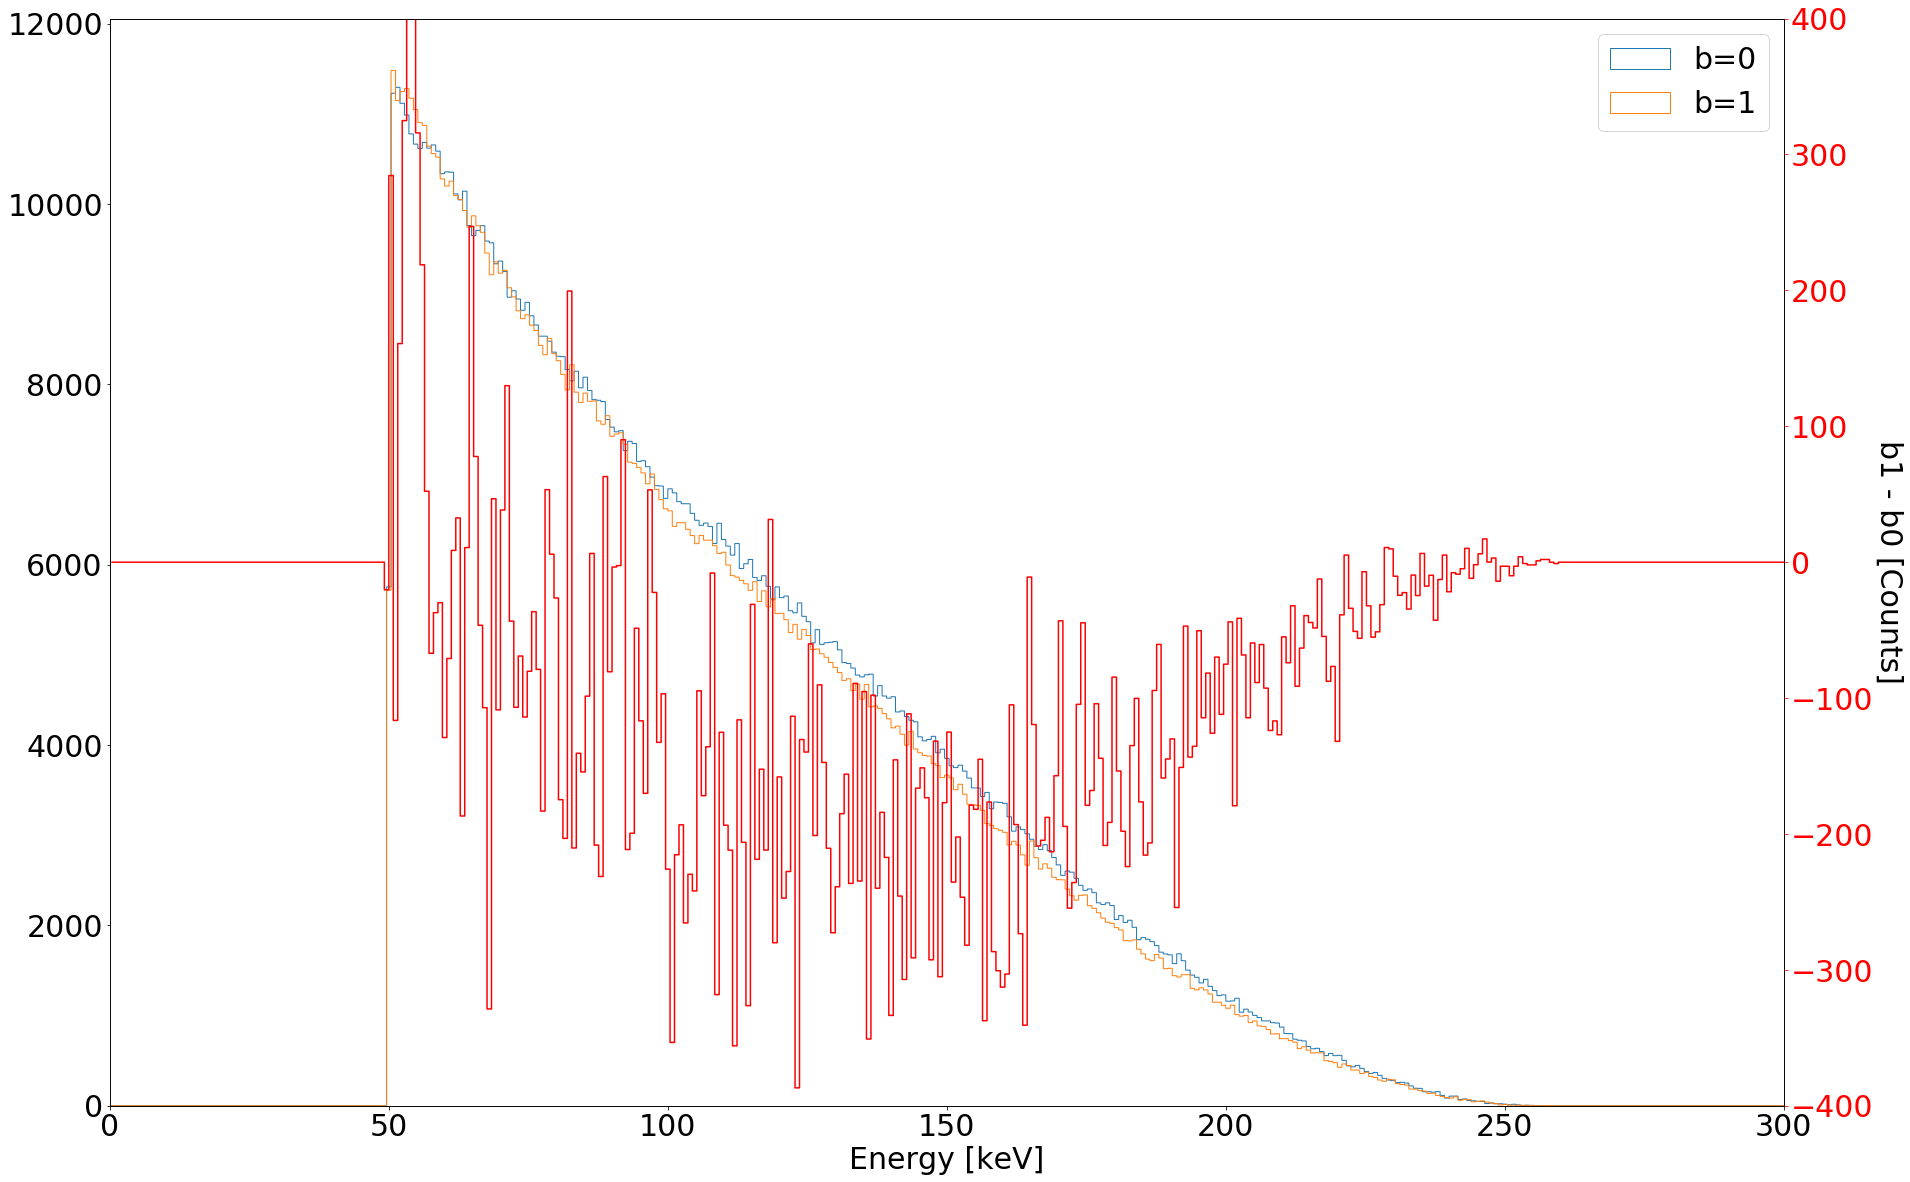

In [57]:
fs=30
fig,ax=subplots(figsize=(30,20))
temph0,tempb,temp=ax.hist(mb0.energy,bins=1000,range=[0,800],histtype='step',label='b=0')
temph1,tempb,temp=ax.hist(mb1.energy,bins=1000,range=[0,800],histtype='step',label='b=1')
tempb=pd.cbins(tempb)
temph1*=Norm_b
ax.tick_params(labelsize=fs)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax1=twinx()
ax1.plot(tempb,temph1-temph0,ds='steps',c='r')
ax1.tick_params(labelsize=fs,colors='r')
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.legend(fontsize=fs)
ax1.set_ylabel('b1 - b0 [Counts]',fontsize=fs,rotation=270,labelpad=30)
ax1.set_ylim(-400,400)
ax.set_xlim(0,300)
show()
del temp,tempb,temph0,temph1

#### Making simulated single pixel histograms with smearing

In [58]:
nbins,rang= 1000, (0,800)                           # 0.8 keV wide bins
b0_hist,bins=histogram([],bins=nbins,range=rang)   #b0 single pixel histogram
b1_hist,bins=histogram([],bins=nbins,range=rang)   #b1 single pixel histogram
b0_hist,b1_hist=b0_hist.astype(float),b1_hist.astype(float)
bins=pd.cbins(bins)



for bdch in bdchs:                                # Looping over bdchs to smear sim pixel-by-pixel
    bd,ch=int(bdch/8),int(bdch%8)
    sigma=detector_response[bdch]                 # Detector response for bd,ch
    mu=400
    trutharray=(mb0.board==bd)*(mb0.channel==ch)  # events in sb0= with bd ch
    temp=histogram(mb0.energy[trutharray],bins=nbins,range=rang)[0]
#     temp=fftconvolve(temp,pd.gauss(bins,mu=mu,sigma=sigma))[mu:mu+len(bins)]   #Convolve histogram w/gaus.
    b0_hist+=temp                                 # Add the smeared histogram to b0_hist
    
    trutharray=(mb1.board==bd)*(mb1.channel==ch)  # events in sb1= with bd ch
    temp=histogram(mb1.energy[trutharray],bins=nbins,range=rang)[0]
#     temp=fftconvolve(temp,pd.gauss(bins,mu=mu,sigma=sigma))[mu:mu+len(bins)]   #Convolve histogram w/gaus.
    b1_hist+=temp                                 # Add the smeared histogram to b0_hist
b1_hist=Norm_b*b1_hist                            # Normalizing the total number of counts in b1 to that of b1

#### The two smeared spectra are shown below

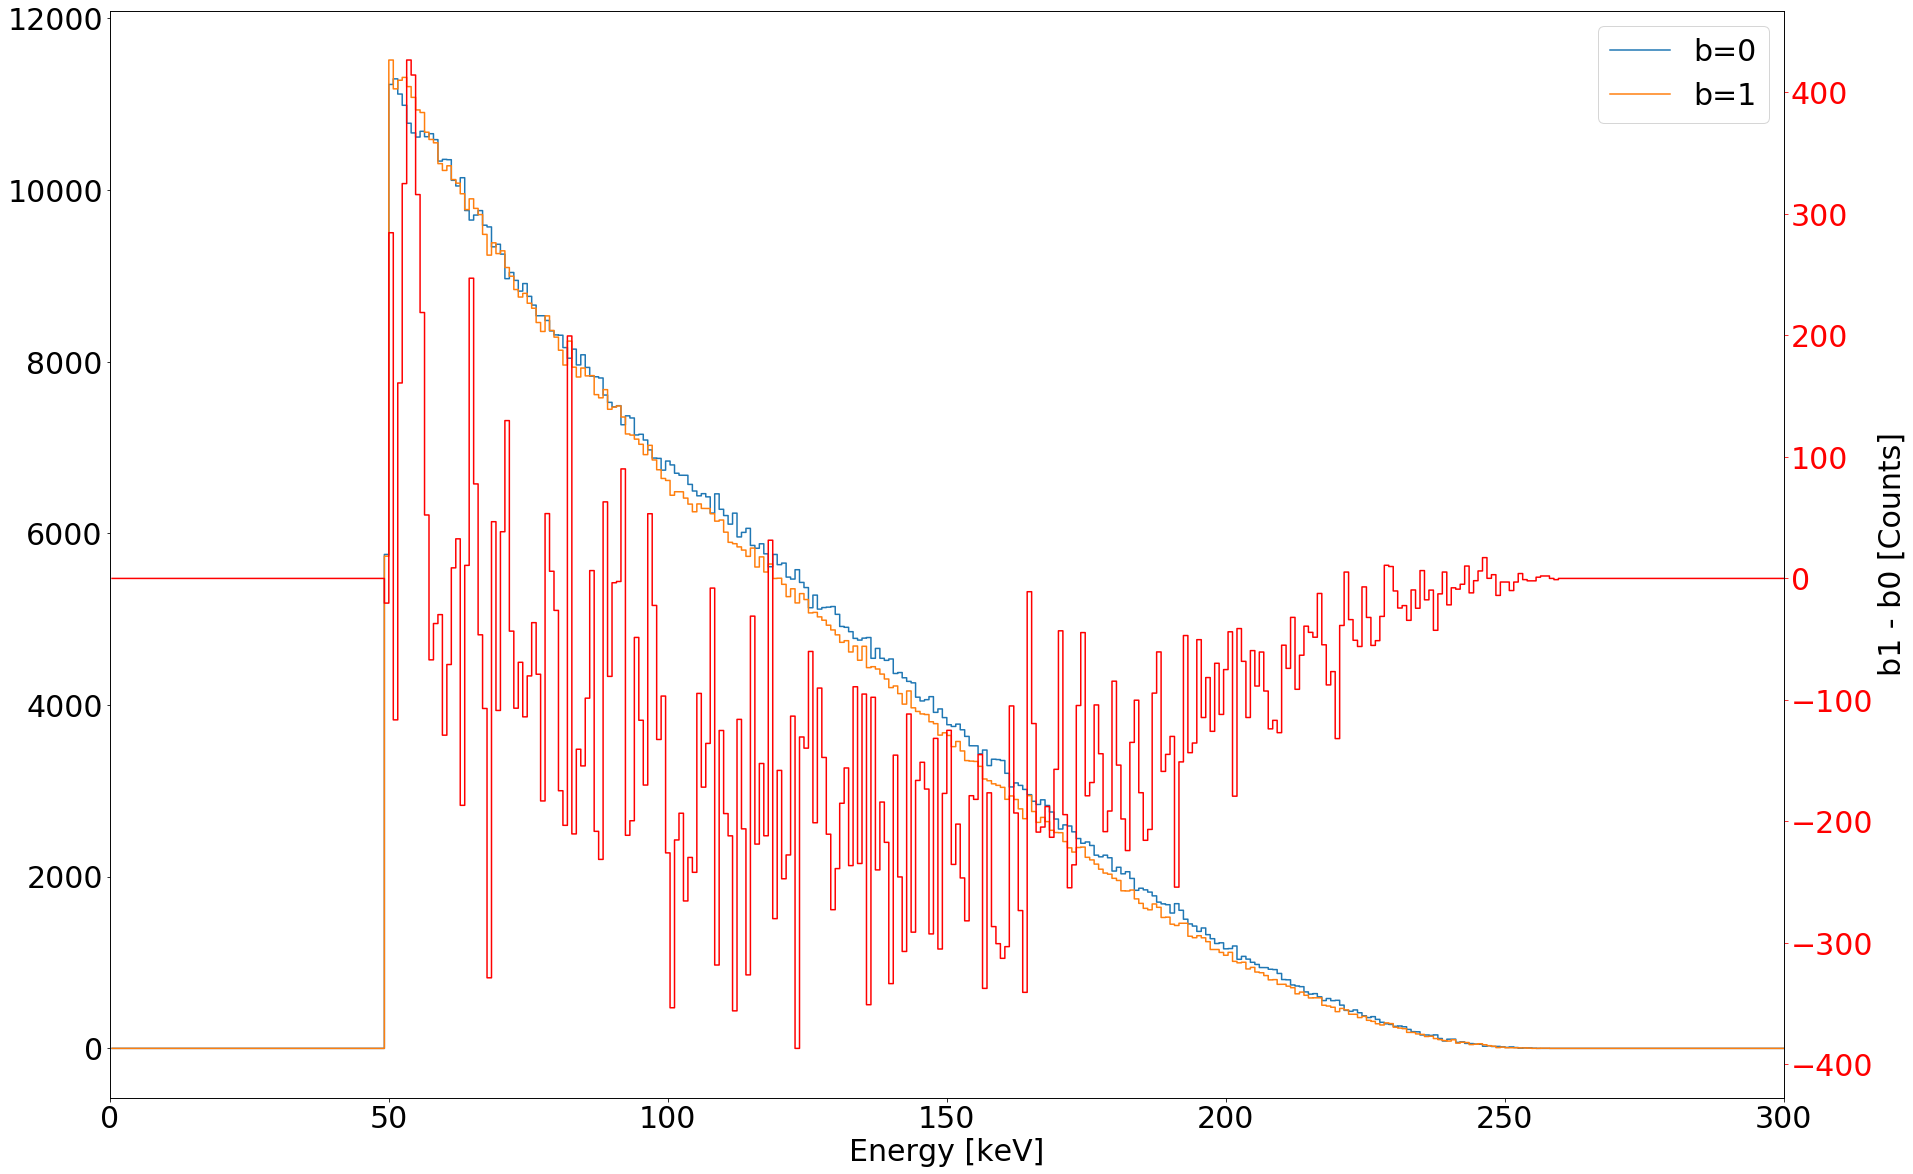

In [59]:
fs=30
fig,ax=subplots(ncols=1,nrows=1,figsize=(30,20))
ax.plot(bins,b0_hist,ds='steps',label='b=0')
ax.plot(bins,b1_hist,ds='steps',label='b=1')
ax.set_xlim(0,300)
ax.set_xlabel('Energy [keV]',fontsize=fs)
ax.tick_params(labelsize=fs)
ax.legend(fontsize=fs)
ax1=twinx()
ax1.plot(bins,b1_hist-b0_hist,c='r',ds='steps')
ax1.tick_params('y', labelsize=fs,colors='r')
ax1.set_ylabel('b1 - b0 [Counts]',fontsize=fs)
show()

---
---
#### Now loading all 45Ca data

In [60]:
path='/home/noah/Desktop/large_analysis/ca_analysis/cur_data/multi_pixel/'
runs=os.listdir(path)
runs=[r for r in runs if r.endswith('T-'+str(thresh)+'.npy')]
runs.sort()
d=np.load(path+runs[0])
for run in runs[1:]:
    print('\r'+30*' ',end='')
    print('\r'+run,end='')
    d=np.concatenate((d,np.load(path+run)))

d=d.view(recarray)                      
osc_amp = 50                            # All WF with an oscillation amp less than osc_amp are included
trutharray = np.sqrt(np.sum(d.osc_amps[:,0:2]**2.,axis=1)) < osc_amp  #OSCILLATION CUT
d=d[trutharray]
d_hist=histogram(d.energy,bins=nbins,range=rang)[0]

Run_99-W-100-T-50.npy         

#### Fitting simulation to data
$$N\left(w(b=0)+b\left[w(b=1)-w(b=0)\right]\right)$$

Sliding window (constant fit length)

In [63]:
b_vals=ndarray(shape=(0,7))    # b | b error | N | N error | X^2/DoF | begin. fit| end fit
stepsize=20
steps=arange(thresh+5,250-stepsize,5)
for beg in steps:
    end=beg+stepsize                 # 20 keV length == 25 points to fit to
    trutharray = (bins>beg)*(bins<end)  # Trutharray for fit window
    weights=sqrt(d_hist[trutharray])  # Statistical weights (erros) only
    X=(trutharray,b0_hist,b1_hist)   # Independent values for curve_fit
    pars,vrs=curve_fit(pd.fierz_fit,X,d_hist[trutharray],\
                      p0=[d_hist[trutharray][0],0],sigma=weights,\
                      epsfcn=1e-3)
    vrs=sqrt(diag(vrs))           #Sqrt of cov. mtx = errors
    chisq=np.sum((d_hist[trutharray]-pd.fierz_fit(X,*pars))**2./d_hist[trutharray])/(np.sum(trutharray)-len(pars))
    out=array([pars[1],vrs[1],pars[0],vrs[0],chisq,beg,end])
    b_vals=vstack((b_vals,out))
names='b,b_error,N,N_error,chisq,beg,end'
formats='f8,f8,f8,f8,f8,f8,f8'
b_vals=fromarrays(b_vals.T,names=names,formats=formats) # Converting to recarray for utility
b_vals=b_vals.view(recarray)
del names,formats


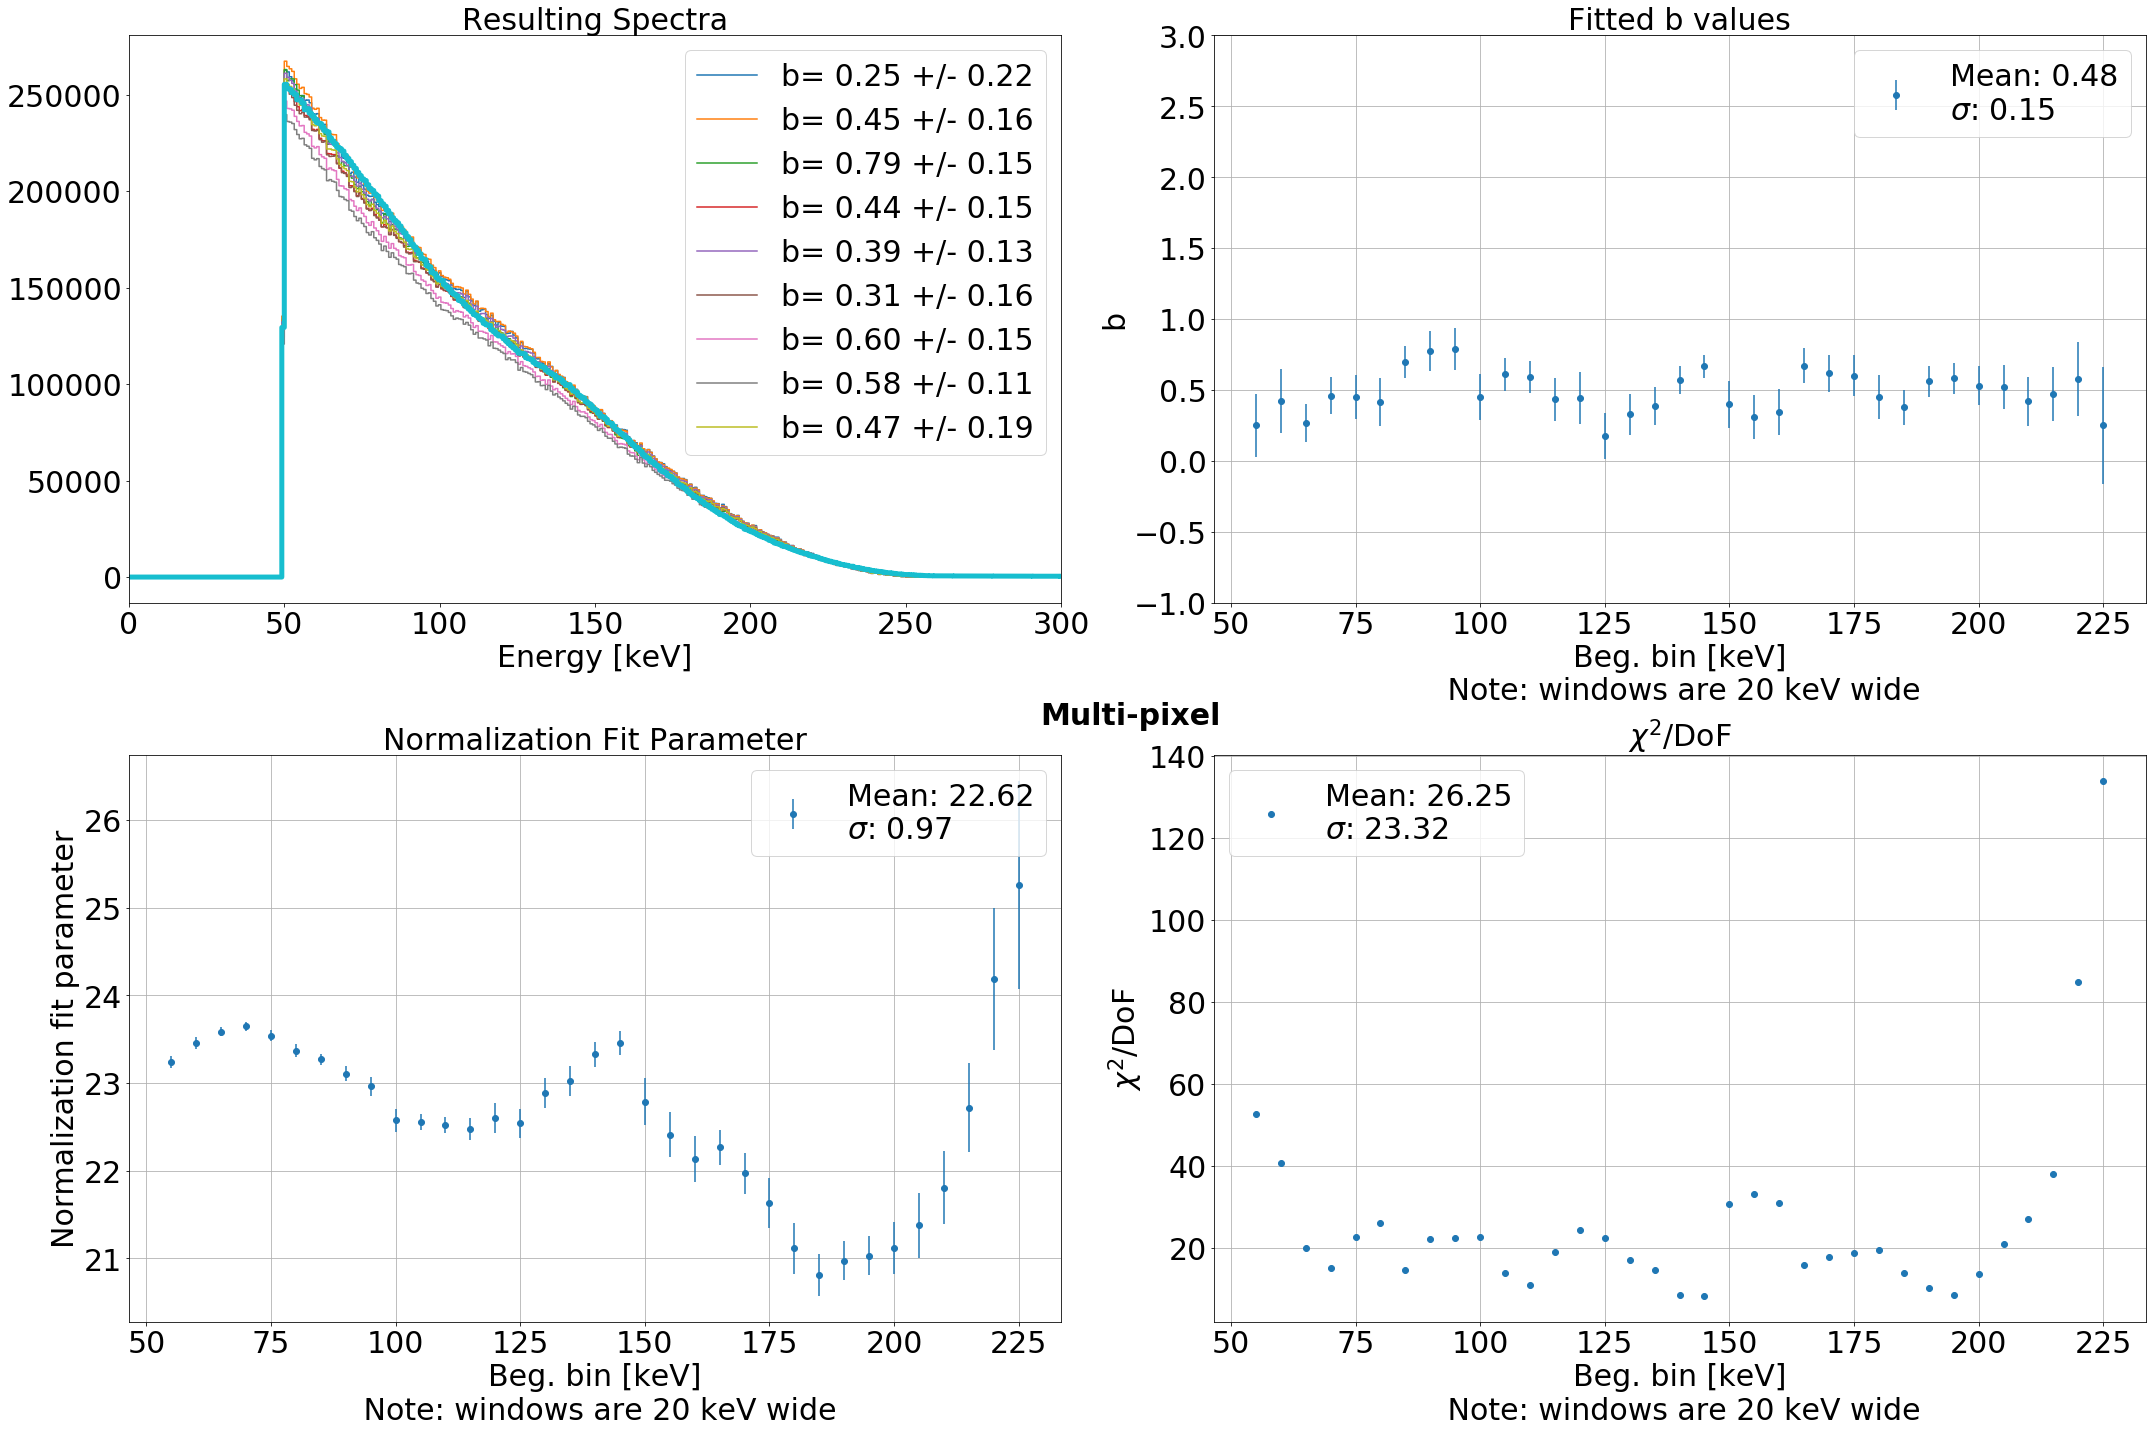

In [64]:
fig,ax=subplots(nrows=2,ncols=2,figsize=(30,20))
for i in range(len(b_vals)):
    vals=b_vals[i]
    X=(np.ones(len(bins),dtype=bool),b0_hist,b1_hist)
    if i%4==0:
        ax[0,0].plot(bins,pd.fierz_fit(X,vals.N,vals.b),ds='steps',label='b= {:0.2f} +/- {:0.2f}'.format(vals.b,vals.b_error))
ax[0,0].legend(fontsize=fs)
ax[0,0].set_xlim(0,300)
ax[0,0].tick_params(labelsize=fs)
ax[0,0].set_title('Resulting Spectra',fontsize=fs)
ax[0,0].set_xlabel('Energy [keV]',fontsize=fs)
ax[0,0].plot(bins,d_hist,ds='steps',lw=5,label='Data')
ax[0,1].errorbar(b_vals.beg,b_vals.b,b_vals.b_error,fmt='o',label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.b.mean())+': {:0.2f}'.format(b_vals.b.std()))
ax[0,1].legend(fontsize=fs)
ax[0,1].tick_params(labelsize=fs)
ax[0,1].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(stepsize),fontsize=fs)
ax[0,1].grid()
ax[0,1].set_ylabel('b',fontsize=fs)
ax[0,1].set_title('Fitted b values',fontsize=fs)
ax[0,1].set_ylim(-1,3)
ax[1,0].errorbar(b_vals.beg,b_vals.N,b_vals.N_error,fmt='o',label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.N.mean())+': {:0.2f}'.format(b_vals.N.std()))
ax[1,0].legend(fontsize=fs)
ax[1,0].tick_params(labelsize=fs)
ax[1,0].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(stepsize),fontsize=fs)
ax[1,0].set_ylabel('Normalization fit parameter',fontsize=fs)
ax[1,0].set_title('Normalization Fit Parameter',fontsize=fs)
ax[1,0].grid()
ax[1,1].plot(b_vals.beg,b_vals.chisq,marker='o',ls='None',label='Mean: {:0.2f}\n'r'$\sigma$'.format(b_vals.chisq.mean())+': {:0.2f}'.format(b_vals.chisq.std()))
ax[1,1].legend(fontsize=fs)
ax[1,1].tick_params(labelsize=fs)
ax[1,1].set_xlabel('Beg. bin [keV]\n Note: windows are {:0d} keV wide'.format(stepsize),fontsize=fs)
ax[1,1].set_ylabel(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].set_title(r'$\chi^2/\mathrm{DoF}$',fontsize=fs)
ax[1,1].grid()
fig.text(0.525,0.5,'Multi-pixel',fontsize=fs,fontweight='bold',horizontalalignment='center',verticalalignment='center')
# ax[1].set_ylim(-2,2)
tight_layout()
savefig('multi-pixel')
show()